### venv location:
activate the following: `~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

In [ ]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptoshow-analysis/src/utils')
sys.path.append('/home/skrhakv/cryptic-nn/src') 
import finetuning_utils # download from https://github.com/skrhakv/cryptic-finetuning/blob/master/src/finetuning_utils.py
from finetuning_utils import FinetunedEsmModel
import eval_utils
from eval_utils import CryptoBenchClassifier

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/models/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False) #, map_location=torch.device('cpu'))

# scPDB-enhanced model
Run scPDB-enhanced model on LIGYSIS (version WITH ions).

In [ ]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/models/gbs-model-enhanced-scPDB.pt'

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/coordinates/ligysis'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/embeddings/sc-PDB'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/data-extraction/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.7

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

predicted_binding_sites = {}
ranks = {}
predicted_binding_sites_without_smoothing = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            f'/tmp/skrhakv/{pdb_id}{chain_id}.npy',
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)

    prediction_indices = np.where(prediction > DECISION_THRESHOLD)[0]
    if prediction_indices.shape[0] == 0:
        predicted_binding_sites[protein_id] = []
        predicted_binding_sites_without_smoothing[protein_id] = []
        continue
    elif prediction_indices.shape[0] == 1:
        clusters = np.array([-1])
    else:
        clusters = eval_utils.compute_clusters(
            coordinates,
            prediction,
            decision_threshold=DECISION_THRESHOLD,
            eps=12,
            min_samples=1,
            method='meanshift',
        )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)
    assert distance_matrix.shape[0] == len(sequence), "Distance matrix size must match sequence length."
    assert distance_matrix.shape[0] == np.load(embeddings_path).shape[0], "Distance matrix size must match number of embeddings."

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_predicted_binding_sites_without_smoothing = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        this_predicted_binding_sites_without_smoothing.append((cluster_residue_indices, 'finetuned model without smoothing'))
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, 
                                                                 chain_id, 
                                                                 cluster_residue_indices, 
                                                                 embeddings_path, 
                                                                 distance_matrix)
        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, 'finetuned model with smoothing'))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0], reverse=True)]
    predicted_binding_sites[protein_id] = this_predicted_binding_sites
    predicted_binding_sites_without_smoothing[protein_id] = this_predicted_binding_sites_without_smoothing


0.6073815751235107 (0.23002034292356874)
Eval method | DCC < 12 | DCC < 4
N+0: 0.22755013077593722 (0.07817494914269107)
N+2: 0.23336239465271724 (0.07962801511188608)
Average number of predicted pockets overlapping actual pockets: 1.1845586640641943 ; median: 1.0


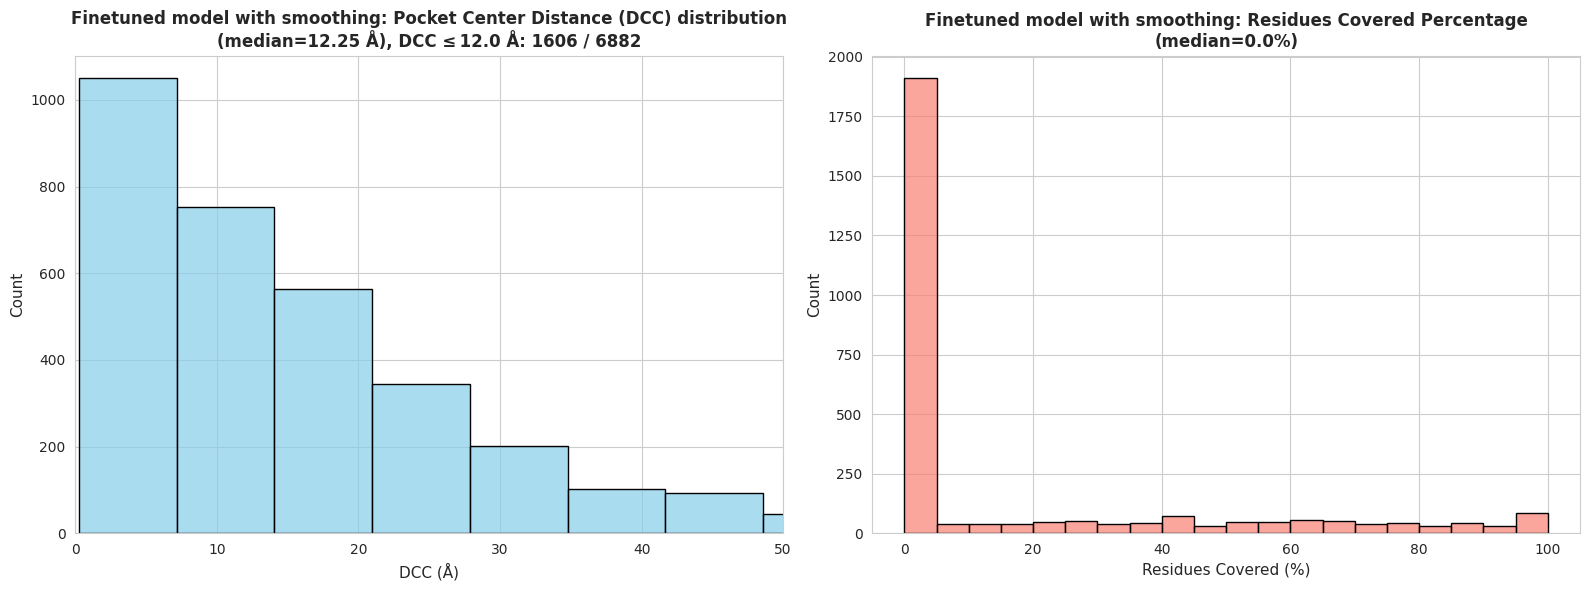

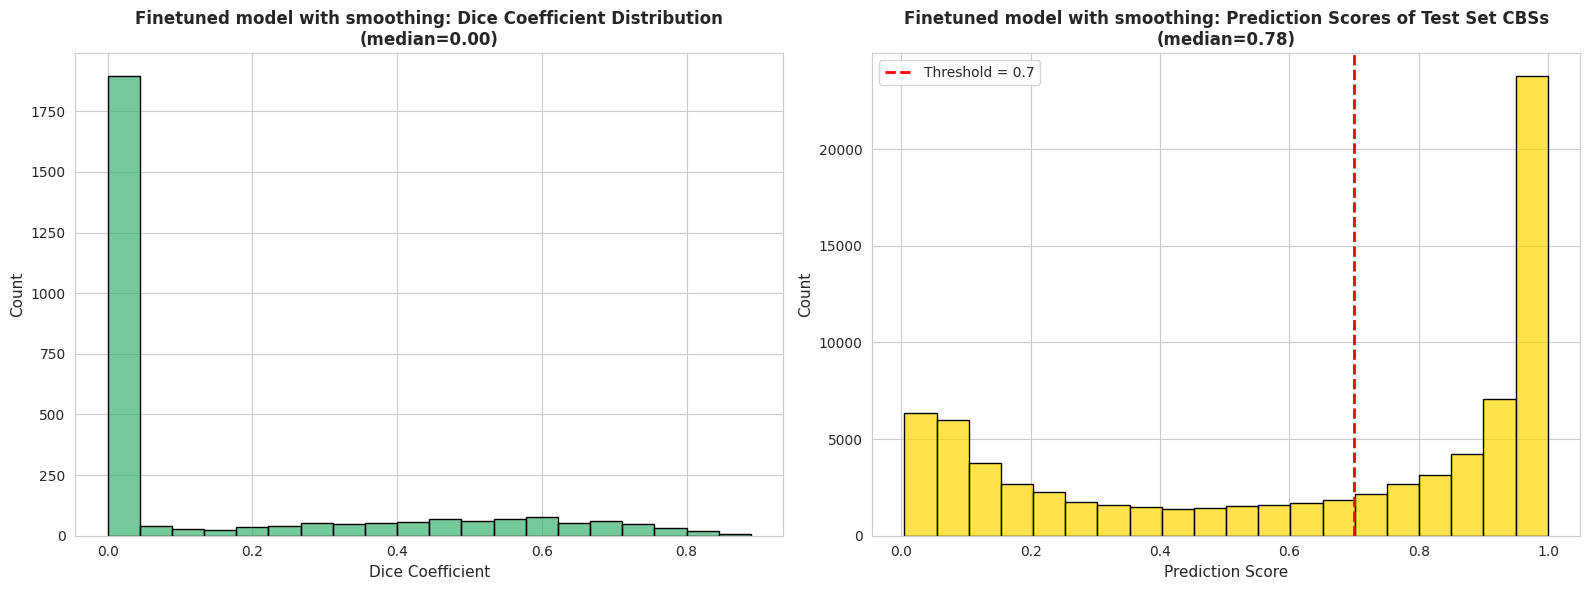

In [ ]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

## Confusion matrix and MCC calculation 
from sklearn import metrics

actual = []
predicted_with_smoothing = []
predicted_without_smoothing = []

for protein_id in binding_residues.keys():
    this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in binding_residues[protein_id]:
        binding_site = [int(i.split('_')[1]) for i in binding_site]
        this_actual[binding_site] = 1
    
    this_predicted_with_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites[protein_id]:
        this_predicted_with_smoothing[binding_site] = 1
    
    this_predicted_without_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites_without_smoothing[protein_id]:
        this_predicted_without_smoothing[binding_site] = 1
    
    predicted_with_smoothing.append(this_predicted_with_smoothing)
    predicted_without_smoothing.append(this_predicted_without_smoothing)
    actual.append(this_actual)

labels = np.concatenate(actual)
predictions_with_smoothing = np.concatenate(predicted_with_smoothing)
predictions_without_smoothing = np.concatenate(predicted_without_smoothing)


number_of_overlapping_actual_sites_on_predicted_pocket = []
for protein_id in sequences.keys():
    for pocket in binding_residues[protein_id]:
        pocket = [int(i.split('_')[1]) for i in pocket]
        number_of_predicted_pockets = 0
        for predicted_pocket, method in predicted_binding_sites[protein_id]:
            if set(pocket).intersection(set(predicted_pocket)):
                number_of_predicted_pockets += 1
        number_of_overlapping_actual_sites_on_predicted_pocket.append(number_of_predicted_pockets)
number_of_overlapping_predictions_on_actual_pocket_without_zeros = [i for i in number_of_overlapping_actual_sites_on_predicted_pocket if i != 0]
print('Average number of predicted pockets overlapping actual pockets:', np.mean(number_of_overlapping_predictions_on_actual_pocket_without_zeros), '; median:', np.median(number_of_overlapping_predictions_on_actual_pocket_without_zeros))


eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)


# FOR FIGURES IN THE PAPER:

# MeanShift with bandwidth=9, threshold=0.7
# 0.6771287416448707 (0.24702121476315025)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.505521650682941 (0.15286253995931415)
# N+2: 0.5318221447253705 (0.17160709096192966)
# Average number of predicted pockets overlapping actual pockets: 2.1386245674740483 ; median: 2.0

# MeanShift with bandwidth=12, threshold=0.7
# 0.6073815751235107 (0.23002034292356874)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.22755013077593722 (0.07817494914269107)
# N+2: 0.23336239465271724 (0.07962801511188608)
# Average number of predicted pockets overlapping actual pockets: 1.1845586640641943 ; median: 1.0

# DBSCAN with eps=5, min_samples=1
# 0.7369950595757048 (0.3247602441150828)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.5816623074687591 (0.14952048823016564)
# N+2: 0.6560592850915432 (0.22885789014821273)
# Average number of predicted pockets overlapping actual pockets: 4.831885317115551 ; median: 4.0

# DBSCAN with eps=7, min_samples=1
# 0.6448706771287417 (0.25414123801220573)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.43751816332461496 (0.14763150247021214)
# N+2: 0.461348445219413 (0.16172624237140365)
# Average number of predicted pockets overlapping actual pockets: 1.5365168539325842 ; median: 1.0

# GMM
# 0.5986631793083406 (0.23190932868352224)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.3561464690496949 (0.11304853240337111)
# N+2: 0.35977913397268235 (0.12104039523394362)
# Average number of predicted pockets overlapping actual pockets: 1.5191268640587854 ; median: 1.0